In [112]:
import os
from pathlib import Path
from pprint import pformat,pprint


import requests
import yfinance as yf
from dotenv import load_dotenv
from langchain.messages import RemoveMessage
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool,Tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from pydantic import BaseModel,Field


In [74]:
# huggingfacehub_api_token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

# llm = HuggingFaceEndpoint(
#     repo_id="Qwen/Qwen2.5-7B-Instruct",
#     task="text-generation",
#     max_new_tokens=2048,
#     do_sample=False,
#     repetition_penalty=1.03,
#     provider="auto",  # let Hugging Face choose the best provider for you
#     huggingfacehub_api_token=huggingfacehub_api_token
# )

# chat_model = ChatHuggingFace(llm=llm)


# llm = HuggingFaceEndpoint(
#     repo_id="Qwen/Qwen2.5-7B-Instruct",
#     max_new_tokens=2048,
#     do_sample=False,
#     huggingfacehub_api_token=huggingfacehub_api_token,
# )

# chat_model = ChatHuggingFace(llm=llm)


In [75]:
class LookupStockInput(BaseModel):
    company_name: str = Field(
        description="The full company name, e.g. Tesla Inc."
    )

class FetchStockInput(BaseModel):
    stock_symbol: str = Field(
        description="Stock ticker symbol, e.g. TSLA"
    )


In [76]:
@tool(args_schema=LookupStockInput)
def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "4CB8FGQ3W6VL4X49",
    }
    response = requests.get(api_url, params=params)
    data = response.json()
    # print(f"Stock data : {data}")

    if "bestMatches" in data and data["bestMatches"]:
        symbol = data["bestMatches"][0]["1. symbol"]
        print(f"symbol : {symbol}")
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."

@tool(args_schema=FetchStockInput)
def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        info = stock.info
        # Historical OHLCV data
        # stock_history = stock.history(period=period).to_dict()

        # Combine both into a single dictionary
        summary = {
            "symbol": stock_symbol,
            "current_price": info.get("currentPrice"),
            "market_cap": info.get("marketCap"),
            "pe_ratio": info.get("trailingPE"),
            "eps": info.get("trailingEps"),
            "52w_high": info.get("fiftyTwoWeekHigh"),
            "52w_low": info.get("fiftyTwoWeekLow"),
            "sector": info.get("sector"),
            "industry": info.get("industry"),
        }

        return pformat(summary)
    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


In [77]:
# System message for financial related queries
Finance_system_message = SystemMessage(
    content=(
        """
            You are a professional financial assistant specializing in stock market analysis and investment strategies. 
            Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
            whether they already hold the stock or are considering investing.

            You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
            Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
            and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
            actionable insights for the user.

            Your responses should be:
            - **Concise and direct**, summarizing only the most critical insights.
            - **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
            - **Context-aware**, considering both current holders and potential investors.
            - **Free of speculation**, relying solely on factual data and trends.

            ### Response Format:
            1. **Recommendation:** Buy, Sell, Hold, or Wait.
            2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
            3. **Suggested Next Steps:** What the user should do based on their current position.
            If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

            Your goal is to help users make informed financial decisions quickly and confidently.
        """
    )
)

# System message for general queries
General_chatbot_system_message = SystemMessage(
    content=(
        """
            You are a helpful and knowledgeable chatbot assistant. 
            Your goal is to provide clear and accurate answers to user questions based on the information they provide. 
            Stay focused, concise, and ensure your responses are relevant to the context of the conversation. 
            If you don’t have enough information, ask for clarification.”
        """
    )
)


In [ ]:
PROJECT_ROOT = Path.cwd().parent
load_dotenv(PROJECT_ROOT / ".env")

GROQ_API_KEY = os.getenv("GROQ_API_KEY_DEFAULT")


In [79]:
# Initialize Groq LLM
llm = ChatGroq(
    api_key=GROQ_API_KEY, 
    model_name="llama-3.1-8b-instant", 
    temperature=0.2,
    max_tokens=1024
)


In [80]:
# Create tool bindings with additional attributes and attach the tools to the llm:
toolbox = [lookup_stock_symbol, fetch_stock_data_raw]

llm_with_tools = llm.bind_tools(
    toolbox,
    tool_choice="auto",
)


In [81]:
print(llm_with_tools)


bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x74ccbdd549b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x74ccac4762a0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=1024) kwargs={'tools': [{'type': 'function', 'function': {'name': 'lookup_stock_symbol', 'description': "Converts a company name to its stock symbol using a financial API.\n\nParameters:\n    company_name (str): The full company name (e.g., 'Tesla').\n\nReturns:\n    str: The stock symbol (e.g., 'TSLA') or an error message.", 'parameters': {'properties': {'company_name': {'description': 'The full company name, e.g. Tesla Inc.', 'type': 'st

In [82]:
class chatState(MessagesState):
    summary: str
    intent: str


In [83]:
def show_state(graph, config):
    snap = graph.get_state(config)
    vals = snap.values

    print("\n================ STATE SNAPSHOT ================")
    print("Intent:", vals.get("intent"))
    print("Summary:", (vals.get("summary") or "")[:300])
    print("Num Messages:", len(vals.get("messages", [])))
    print("Messages:")

    for m in vals.get("messages", []):
        msg_type = type(m).__name__

        # 🔹 ToolMessage → print minimal info
        if isinstance(m, ToolMessage):
            content_preview = str(m.content)
            content_preview = (
                content_preview[:200] + "..."
                if len(content_preview) > 200
                else content_preview
            )

            print("- ToolMessage:")
            print(f"    tool_name : {m.name}")
            print(f"    content   : {content_preview}")

        # 🔹 Normal messages → print fully
        else:
            print(f"- {msg_type}: {m.content}")

            # Print tool calls if present (AIMessage)
            if hasattr(m, "tool_calls") and m.tool_calls:
                print("    TOOL CALLS:")
                for tc in m.tool_calls:
                    print(f"      - name: {tc['name']}, args: {tc['args']}")

    print("================================================\n")


In [84]:
def detect_intent_node(state: chatState) -> chatState:
    """
    Simple keyword-based intent detection.
    """
    # get the lastest user message content
    last_user_msg = state["messages"][-1].content.lower()

    finance_keywords = [
        "stock",
        "share",
        "price",
        "buy",
        "sell",
        "market",
        "investment",
        "portfolio",
        "nifty",
        "sensex",
        "invest"
    ]

    # Determine the intent bases of basic key-word matching in the users messgage
    intent = (
        "finance" if any(k in last_user_msg for k in finance_keywords) else "genral"
    )

    print(f"[INTENT DETECTED] → {intent}")

    return {"intent": intent}


In [85]:
# This is the main chat node - The brain of the graph - which detects The intent and then appends specific system message along with the summarization
def chat_node(state: chatState) -> chatState:
    """
    Uses intent to select the correct system message
    and includes conversation summary if available.
    """
    messages = []

    # inject the summary if present in the state
    if state.get("summary"):
        messages.append(
            SystemMessage(
                content=f"summary of the ongoing conversation till now : \n{state['summary']}"
            )
        )

    # Based on the user intent, set the system prompt message of the Chatbot system and the model(with or without tools):
    if state["intent"] == "finance":
        # if it is a finance related question then append the Finance system prompt along with llm_with_tools
        messages.append(Finance_system_message)
        model = llm_with_tools
        print("[CHAT] Finance mode → tools enabled")
    else:
        # else general system prompt along with basic tool
        messages.append(General_chatbot_system_message)
        model = llm
        print("[CHAT] General mode → no tools")

    # Add conversation messages (current user message):
    messages.extend(state["messages"])

    print("[CHAT NODE] Sending messages to LLM...")

    # Get the response of the current user ques (summary + SystemPrompt + Current Ques):
    response = model.invoke(messages)

    # store the response in messages:
    return {"messages": [response]}


In [86]:
'''
- Summarize the previous messages from the chathistory , if len(messages) in state > 6 , for eg 7,8... so on
- If len(messages) in state is < 6 , Then no summary - just send the messages to llm;
- If len(messages) in state is > 6 , Then summary exists - send the [Summary + recent mssages] to llm
- 2 possibilities - initially for the first time summary is generated , or summary already exists and we need to update the summary
'''


'\n- Summarize the previous messages from the chathistory , if len(messages) in state > 6 , for eg 7,8... so on\n- If len(messages) in state is < 6 , Then no summary - just send the messages to llm;\n- If len(messages) in state is > 6 , Then summary exists - send the [Summary + recent mssages] to llm\n- 2 possibilities - initially for the first time summary is generated , or summary already exists and we need to update the summary\n'

In [87]:
def summarize_node(state: chatState):
    # Fetch the existing summary of conversation from the state
    existing_summary = state.get("summary", "")

    # Build summarization prompt bases on the existing_summary value

    # if existing_summary exists:
    if existing_summary:
        summary_message = HumanMessage(
            content=(
                f"""
                    Expand the summary below by incorporating the above conversation while preserving context, key points, and 
                    user intent. Rework the summary if needed. Ensure that no critical information is lost and that the 
                    conversation can continue naturally without gaps. Keep the summary concise yet informative, removing 
                    unnecessary repetition while maintaining clarity.
                    
                    Only return the updated summary. Do not add explanations, section headers, or extra commentary.

                    Existing summary:

                    {existing_summary}
                """
            )
        )

    else:
        # if no summary exists create a one for the given conversation
        summary_message = HumanMessage(
            content="""
                Summarize the above conversation while preserving full context, key points, and user intent. Your response should be concise yet detailed enough to ensure seamless continuation of the discussion. Avoid redundancy, Maintain clarity, and retain all necessary details for future exchanges.
                Only return the summarized content. Do not add explanations, section headers, or extra commentary.
            """
        )

    # Add prompt with the recent state messages:
    messages_with_summary = state["messages"] + [summary_message]

    # Invoke the llm with the summary and recent messgaes to create new summary or update the existing one:
    response = llm_with_tools.invoke(messages_with_summary)

    # Keep only the lastest(newest) 2 messages in the state["message"] rest all goes to the delete_message(as we dont need them -> summary has been created for the same)
    messages_to_delete = state["messages"][:-2]

    print("[SUMMARIZATION] Conversation summarized.")

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }


In [88]:
def route_after_chat(state: chatState):
    """
    Decide whether to:
    - run tools
    - summarize
    - end
    """
    last_msg = state["messages"][-1]

    # If LLM requested tools → go to ToolNode
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"

    # Otherwise check summarization
    if len(state["messages"]) > 4:
        return "summarize"

    return END


In [89]:
"""
This graph orchestrates the control flow between:
- intent detection
- LLM reasoning
- tool execution
- memory summarization
"""
builder = StateGraph(chatState)


# Detects whether the user's query is finance-related or general
builder.add_node("detect_intent_node", detect_intent_node)

"""
Main reasoning node:
- Injects summary (if present)
- Injects intent-based system prompt
- Decides whether to call tools or produce final output
"""
builder.add_node("chat_node", chat_node)

# Executes tool calls requested by the LLM
builder.add_node("tools", ToolNode(toolbox))

# Compresses conversation history when it grows too large
builder.add_node("summarize", summarize_node)


In [90]:
# Define edges: these determine how the control flow moves

# Entry point of the graph:Every invocation starts by detecting user intent
builder.add_edge(START, "detect_intent_node")

# with classified intent move to chat node where ( summary(if Present) + SystemPrompt_Intent_Based + Current Ques) is initialized
builder.add_edge("detect_intent_node", "chat_node")

"""
Based on the LLM's output, we decide:
1. Run tools (if tool_calls are present)
2. Summarize memory (if message count exceeds threshold)
3. End execution (final answer is ready)
"""
builder.add_conditional_edges(
    "chat_node",
    route_after_chat,
    {
        "tools": "tools",
        "summarize": "summarize",
        END: END,
    },
)

# After tools → go back to chat - # This allows the LLM to: Read tool results , Continue reasoning , Possibly call more tools or produce final answ
builder.add_edge("tools", "chat_node")

builder.add_edge("summarize", END)


In [91]:
# Initialize the Inmemory saver:
memory = InMemorySaver()

# The checkpointer saves the graph snap shpt at various different endpoints(at each node basically)
graph = builder.compile(checkpointer=memory)


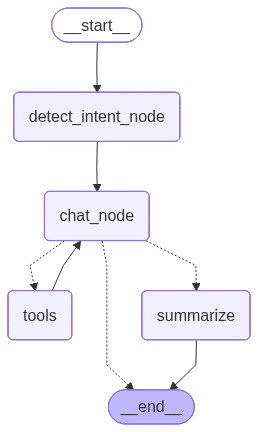

In [92]:
graph


In [93]:
# config = {"configurable": {"thread_id": "user-1"}}

# graph.invoke(
#     {"messages": [HumanMessage(content="what is reducer in lang-graph")]},
#     config=config,
# )

# show_state(graph, config)


In [94]:
# config = {"configurable": {"thread_id": "user-2"}}

# user_input = HumanMessage(content="Hi, I’m working on a Python project, and I’m stuck with handling API responses.")
# for event in graph.stream({"messages":[user_input]},config=config,stream_mode="values"):
#     for m in event['messages']:
#         m.pretty_print()
#     print("\n")
#     print("#"*100)
#     print("\n")


In [95]:
# config = {"configurable": {"thread_id": "user-1"}}

# user_input = HumanMessage(content="Should I invest in Google stocks")

# graph.invoke(
#     {"messages":[user_input]},
#     config=config
# )

# show_state(graph,config)


In [96]:
# from langgraph_sdk import get_client

# URL = "http://localhost:61693"
# client = get_client(url=URL)

# assistants = await client.assistants.search()
# assistants


In [97]:
# from langchain_core.messages import convert_to_messages

# thread = await client.threads.create()
# input_message = HumanMessage(content="Should I invest in Tesla stocks?")

# async for event in client.runs.stream(
#             thread["thread_id"], 
#             assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
#             input={"messages": [input_message]}, 
#             stream_mode="values"):
#     messages = event.data.get('messages',None)
#     if messages:
#         print(convert_to_messages(messages)[-1])


### Adding a Breakpoint in the Graph Execution


In [98]:
graph = builder.compile(interrupt_before=["tools"],checkpointer=memory)


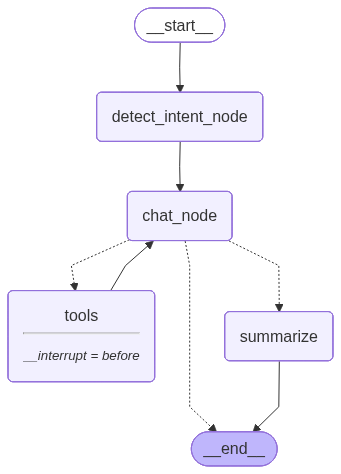

In [99]:
graph


#### Testing the BreakPoint


In [100]:
# # start a new conversation
# thread = {"configurable": {"thread_id": "1"}}

# # define intiial user request
# initial_input = {"messages": HumanMessage(content="Should I invest in Tesla stocks?")}

# # run the graph and stream in values mode
# for event in graph.stream(initial_input, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()


In [101]:
# since we interrupted the current workflow before the tool node , lets see the current state
# state = graph.get_state(thread)
# state


In [102]:
# lets see whats the next node which will be called in the state:
# state.next


##### Resuming execution

###### - Initializes a new execution flow based on the provided initial_input :

###### - graph.stream(initial_input, thread, stream_mode="values")

###### - resumes from the latest checkpoint stored in the thread state

###### - graph.stream(None, thread, stream_mode="values")

###### - Passing None as initial_input tells LangGraph: “Continue execution from where it left off for the given thread_id.”

###### - By setting initial_input = None, you’re not reinitializing the graph but rather instructing it to continue from the last recorded execution point for the given thread_id. This mechanism ensures smooth, stateful interactions, making cyclic approvals and multi-step workflows possible


In [103]:
# as a first event LangGraph re-emits the current state (AIMessage with the tool call - which fetches the stock symbol) and after that Resumes the execution to Next Tool Call (fetch_raw_data).

# for event in graph.stream(None, thread, stream_mode="values"):
#     event['messages'][-1].pretty_print()


### Combining all Together


In [ ]:
thread = {"configurable": {"thread_id": "5"}}

initial_input = {"messages": HumanMessage(content="Is the following better than the Nvidia Stock?")}

current_state_reemit = False

# Run the following graph in a loop , pausing before each tool node:
while True:
    # Reset flag at the start of each while-loop iteration
    should_restart = False  

    # Run the graph until the next interruption (breakpoint before tool-node)
    for event in graph.stream(initial_input , thread , stream_mode="values"):
        event["messages"][-1].pretty_print()
        
        # Check if a tool is about to be called - as we have Interruption Before tool node:
        if "tool_calls" in event["messages"][-1].additional_kwargs:

            # if current_state_reemit is True then make it False and continue
            if current_state_reemit:
                current_state_reemit = False
                continue

            # if already False
            else:
                # get the specific tool name:
                tool_name = event["messages"][-1].additional_kwargs["tool_calls"][0]["function"]["name"]

                # Get user feedback
                user_approval = input(f"Do you want to call the tool {tool_name}? (yes/no): ")

                if user_approval.lower() == "yes":
                    initial_input = None
                    current_state_reemit = True
                    should_restart = True
                else:
                    print(f"\n\nTool call {tool_name} was cancelled by user")
                break

    if should_restart:
        continue
    
    # Once the graph completes without hitting a tool node, break out of the loop
    break


In [ ]:
show_state(graph,thread)


In [106]:
# Ollama
# Docker
# MCP
# Sunny Savita
# Build DeepSeek from Scratch: Series Introduction - yt Playlist - Vizuara  


In [ ]:
# here we are interrupting before chat_node 
graph = builder.compile(interrupt_before=["chat_node"], checkpointer=memory)

# Getting the current Graph State
state = graph.get_state(thread)
pprint(state)


In [ ]:
# updating the graph's state by adding a new message:
graph.update_state(thread, {"messages": [HumanMessage(content="No sorry, I changed my mind. I would be more interested in Apple stocks!")]})

# checking the graph's state and printing the messages:
messages = graph.get_state(thread).values['messages']
for message in messages:
    message.pretty_print()


In [ ]:
# resuming the grapg
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()
